## Making data

## Make DataFrame of circle data

In [96]:
import pandas as pd
import numpy as np
from helper_functions import *

In [3]:
df = pd.DataFrame(np.hstack((X,y.reshape(n_samples, -1))), columns=['X1', 'X2', 'label'])
df

,X1,X2,label
0,0.754246,0.231481,1.0
1,-0.756159,0.153259,1.0
2,-0.815392,0.173282,1.0
3,-0.393731,0.692883,1.0
4,0.442208,-0.896723,0.0
...,...,...,...
995,0.244054,0.944125,0.0
996,-0.978655,-0.272373,0.0
997,-0.136900,-0.810012,1.0
998,0.670362,-0.767502,0.0


In [4]:
df['label'].value_counts()

1.0    500
0.0    500
Name: label, dtype: int64

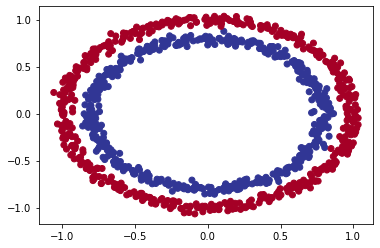

In [5]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [6]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

## Turn data into tensors

In [7]:
import torch 
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [8]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [9]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [113]:
class ClassifierCircleV0(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    
    def forward(self,x):
        return self.layer_2(self.layer_1(x))
model_0 = ClassifierCircleV0()
model_0

ClassifierCircleV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [11]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.0649,  0.4706],
                      [ 0.1131, -0.2995],
                      [ 0.4023,  0.6891],
                      [-0.6523,  0.0312],
                      [ 0.3423, -0.0599]])),
             ('layer_1.bias',
              tensor([ 0.1869,  0.2233,  0.2595, -0.4306,  0.4537])),
             ('layer_2.weight',
              tensor([[ 0.2699, -0.1688,  0.2048, -0.1537,  0.1292]])),
             ('layer_2.bias', tensor([-0.1744]))])

In [114]:
# Make predictions with the model
untrained_preds = model_0(X_test)
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")


Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667],
        [-0.1484],
        [-0.0826],
        [-0.0946],
        [-0.1918],
        [-0.0944]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [13]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
bce_loss = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
sgd_optim = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

In [115]:
# View the frist 5 outputs of the forward pass on the test data
y_logistic = model_0(X_test)[:5]
y_logistic

tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667]], grad_fn=<SliceBackward0>)

In [15]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logistic)
y_pred_probs

tensor([[0.5384],
        [0.5777],
        [0.4467],
        [0.5641],
        [0.4663]], grad_fn=<SigmoidBackward0>)

In [116]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test)[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

RuntimeError: The size of tensor a (4) must match the size of tensor b (5) at non-singleton dimension 1

In [17]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [18]:
# Calculate accuracy (a classification metric)
def accuracy_score(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

## Training

In [ ]:
def training_model(model: torch.nn.Module, loss_fn, optimizer, 
                   X_train=X_train
                   ,y_train=y_train
                   ,X_test=X_test
                   ,y_test=y_test
                   ,epochs=1000):
    
    # Put data to target device
    X_train, y_train = X_train, y_train
    X_test, y_test = X_test, y_test
    
    for epoch in range(epochs):
        model.train()
        
        y_logistic = model(X_train).squeeze()
        y_preds = torch.round(torch.sigmoid(y_logistic))
        
        loss = loss_fn(y_logistic, y_train)
        acc = accuracy_score(y_preds, y_train)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        model.eval()
        
        with torch.inference_mode():
            test_logistic = model(X_test).squeeze()
            test_preds = torch.round(torch.sigmoid(test_logistic))
            
            test_loss = loss_fn(test_logistic, y_test)
            test_acc = accuracy_score(test_preds, y_test)
            if epoch % 10 == 0:
                print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
    return model

In [20]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.0649,  0.4706],
                      [ 0.1131, -0.2995],
                      [ 0.4023,  0.6891],
                      [-0.6523,  0.0312],
                      [ 0.3423, -0.0599]])),
             ('layer_1.bias',
              tensor([ 0.1869,  0.2233,  0.2595, -0.4306,  0.4537])),
             ('layer_2.weight',
              tensor([[ 0.2699, -0.1688,  0.2048, -0.1537,  0.1292]])),
             ('layer_2.bias', tensor([-0.1744]))])

In [21]:
model_0 = training_model(model_0, bce_loss, sgd_optim)

Epoch: 0 | Loss: 0.69761, Accuracy: 51.62% | Test loss: 0.70853, Test acc: 47.50%
Epoch: 10 | Loss: 0.69668, Accuracy: 51.25% | Test loss: 0.70655, Test acc: 46.50%
Epoch: 20 | Loss: 0.69601, Accuracy: 51.00% | Test loss: 0.70502, Test acc: 45.50%
Epoch: 30 | Loss: 0.69549, Accuracy: 50.75% | Test loss: 0.70379, Test acc: 45.50%
Epoch: 40 | Loss: 0.69507, Accuracy: 50.75% | Test loss: 0.70276, Test acc: 45.50%
Epoch: 50 | Loss: 0.69474, Accuracy: 50.75% | Test loss: 0.70190, Test acc: 45.50%
Epoch: 60 | Loss: 0.69446, Accuracy: 50.88% | Test loss: 0.70116, Test acc: 45.50%
Epoch: 70 | Loss: 0.69424, Accuracy: 50.75% | Test loss: 0.70051, Test acc: 45.50%
Epoch: 80 | Loss: 0.69405, Accuracy: 50.75% | Test loss: 0.69995, Test acc: 45.50%
Epoch: 90 | Loss: 0.69389, Accuracy: 50.62% | Test loss: 0.69945, Test acc: 45.50%
Epoch: 100 | Loss: 0.69375, Accuracy: 50.50% | Test loss: 0.69901, Test acc: 45.50%
Epoch: 110 | Loss: 0.69364, Accuracy: 50.50% | Test loss: 0.69862, Test acc: 45.50%
Epo

In [22]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.1127,  0.4081],
                      [ 0.1418, -0.2615],
                      [ 0.3883,  0.6665],
                      [-0.6288,  0.0626],
                      [ 0.3155, -0.0942]])),
             ('layer_1.bias',
              tensor([ 0.2052,  0.2124,  0.2630, -0.4393,  0.4643])),
             ('layer_2.weight',
              tensor([[ 0.1833, -0.0991, -0.0494, -0.0640,  0.1186]])),
             ('layer_2.bias', tensor([-0.0859]))])

In [23]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


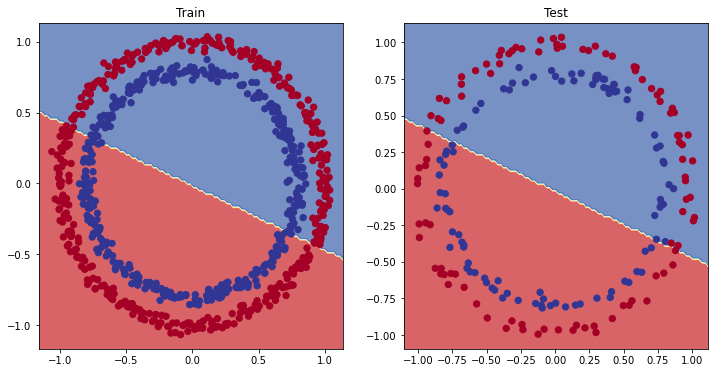

In [24]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## Improving a model
- Add more layers.
- Add more hidden units
- Fitting for longer(more epochs)
- Changing activation functions
- Changing learning rate
- Changing loss function
- Use transfer learning

In [25]:
## Adding more layers and more hidden units
class ClassifierCirclesV1(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
model_1 = ClassifierCirclesV1()
model_1

ClassifierCirclesV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [26]:
# loss and optimal function
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01, momentum=0.7)


In [27]:
model_1 = training_model(model_1, loss_fn, optimizer, epochs=100)

Epoch: 0 | Loss: 0.70200, Accuracy: 50.00% | Test loss: 0.69985, Test acc: 50.00%
Epoch: 10 | Loss: 0.69962, Accuracy: 50.00% | Test loss: 0.69758, Test acc: 50.00%
Epoch: 20 | Loss: 0.69747, Accuracy: 50.00% | Test loss: 0.69580, Test acc: 50.00%
Epoch: 30 | Loss: 0.69605, Accuracy: 50.00% | Test loss: 0.69469, Test acc: 50.00%
Epoch: 40 | Loss: 0.69511, Accuracy: 50.00% | Test loss: 0.69402, Test acc: 50.00%
Epoch: 50 | Loss: 0.69449, Accuracy: 50.00% | Test loss: 0.69363, Test acc: 50.00%
Epoch: 60 | Loss: 0.69407, Accuracy: 50.00% | Test loss: 0.69340, Test acc: 50.00%
Epoch: 70 | Loss: 0.69378, Accuracy: 50.00% | Test loss: 0.69329, Test acc: 50.00%
Epoch: 80 | Loss: 0.69358, Accuracy: 50.00% | Test loss: 0.69325, Test acc: 50.00%
Epoch: 90 | Loss: 0.69344, Accuracy: 46.00% | Test loss: 0.69324, Test acc: 45.00%


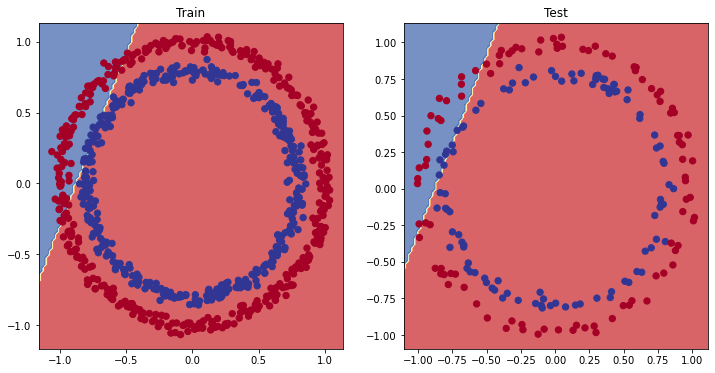

In [28]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## Adding activation function

In [33]:
import torch.nn.functional as F

In [ ]:
class ClassifierCirclesV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        # self.relu = nn.ReLU()
    def forward(self, x):
        return self.layer_3(F.relu(
            self.layer_2(F.relu(
                self.layer_1(x)
            ))
        ))
model_2 = ClassifierCirclesV1()
print(model_2)

In [ ]:
# Fit the model
epochs = 100

# Put all data on target device
X_train, y_train = X_train, y_train
X_test, y_test = X_test, y_test

for epoch in range(epochs):
    model_2.train()
    
    # 1. Forward pass
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_score(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
     
    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_2(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_score(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

In [38]:
# Make predictions
model_2.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_2(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

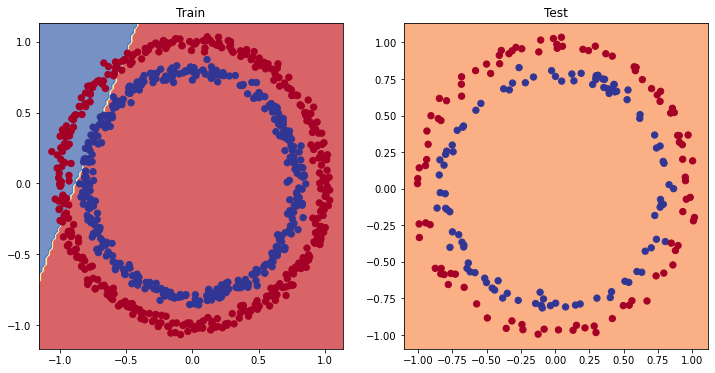

In [39]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test) # model_3 = has non-linearity

## Multi-classification

### Making dataset

In [66]:
import torch
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [149]:
# Set hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42
X_blob, y_blob = make_blobs(
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    random_state=RANDOM_SEED,
    # cluster_std=1.5,
    n_samples=1000
)
X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.float32)


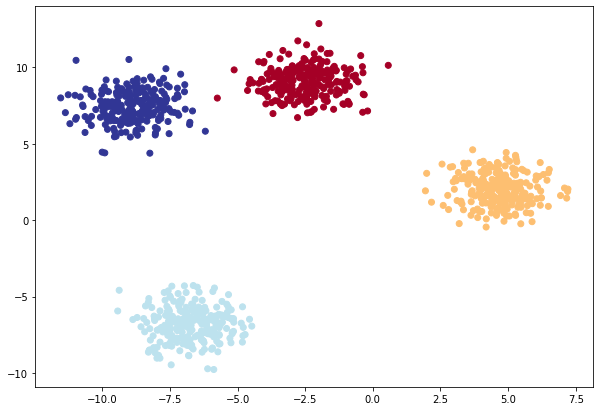

In [150]:
# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [151]:
y_one_hot = torch.zeros((1000, 4))
y_one_hot[range(1000),y_blob.numpy()] = 1
y_one_hot_train, y_one_hot_test = y_one_hot[:len(y_blob_train)], y_one_hot[len(y_blob_train):]

In [152]:
y_one_hot[:10], y_blob[:10]

(tensor([[0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.]]),
 tensor([3., 2., 2., 1., 1., 2., 1., 2., 2., 1.]))

In [153]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [154]:
from torch import nn

### Building model 

In [171]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
            # nn.ReLU(),
        )
    def forward(self, x):
        return self.linear_layer_stack(x)
# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [172]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train)[:5]

tensor([[-1.2096, -0.5905, -1.3977, -0.6999],
        [ 0.2225, -1.5206,  0.0469,  1.1367],
        [ 2.6882,  0.8213,  3.1033,  1.3287],
        [ 2.0801,  0.4201,  2.3750,  1.1485],
        [ 0.4390, -1.3168,  0.3150,  1.1549]], grad_fn=<SliceBackward0>)

In [173]:
# How many elements in a single prediction sample?
model_4(X_blob_train)[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

In [174]:
# Make prediction logits with model
y_logits = model_4(X_blob_test)

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.1988, -0.6983, -1.4013, -0.6101],
        [ 1.7765, -1.2490,  1.7994,  2.1650],
        [ 2.2684,  0.7261,  2.6267,  1.0674],
        [-0.8950, -0.4057, -1.0242, -0.5896],
        [-0.2137, -1.5658, -0.4405,  0.8248]], grad_fn=<SliceBackward0>)
tensor([[0.1898, 0.3131, 0.1550, 0.3420],
        [0.2820, 0.0137, 0.2885, 0.4158],
        [0.3395, 0.0726, 0.4858, 0.1021],
        [0.2055, 0.3351, 0.1806, 0.2789],
        [0.2049, 0.0530, 0.1633, 0.5788]], grad_fn=<SliceBackward0>)


In [175]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [176]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1898, 0.3131, 0.1550, 0.3420], grad_fn=<SelectBackward0>)
tensor(3)


In [177]:
# Fit the model
torch.manual_seed(42)

# Create the loss and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.05)
# Set number of epochs
epochs = 1000

# Put data to target device
X_blob_train, y_blob_train = X_blob_train, y_blob_train
X_blob_test, y_blob_test = X_blob_test, y_blob_test

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_pred)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_one_hot_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.no_grad():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_one_hot_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.04998, Acc: 68.50% | Test Loss: 0.96290, Test Acc: 70.50%
Epoch: 10 | Loss: 0.67884, Acc: 67.50% | Test Loss: 0.67415, Test Acc: 70.00%
Epoch: 20 | Loss: 0.64871, Acc: 33.25% | Test Loss: 0.64124, Test Acc: 40.50%
Epoch: 30 | Loss: 0.63584, Acc: 49.75% | Test Loss: 0.62728, Test Acc: 51.00%
Epoch: 40 | Loss: 0.62700, Acc: 49.75% | Test Loss: 0.61833, Test Acc: 51.00%
Epoch: 50 | Loss: 0.61981, Acc: 49.75% | Test Loss: 0.61145, Test Acc: 51.00%
Epoch: 60 | Loss: 0.61352, Acc: 49.75% | Test Loss: 0.60566, Test Acc: 51.00%
Epoch: 70 | Loss: 0.60784, Acc: 49.75% | Test Loss: 0.60057, Test Acc: 51.00%
Epoch: 80 | Loss: 0.60265, Acc: 49.75% | Test Loss: 0.59600, Test Acc: 51.00%
Epoch: 90 | Loss: 0.59790, Acc: 49.75% | Test Loss: 0.59185, Test Acc: 51.00%
Epoch: 100 | Loss: 0.59356, Acc: 49.75% | Test Loss: 0.58809, Test Acc: 51.00%
Epoch: 110 | Loss: 0.58960, Acc: 49.75% | Test Loss: 0.58468, Test Acc: 51.00%
Epoch: 120 | Loss: 0.58600, Acc: 50.12% | Test Loss: 0.58159, T

In [178]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-0.9907, -1.0735, -1.1687, -1.1687],
        [-1.0464, -1.2098, -1.0443, -1.1064],
        [-1.4100, -0.9239, -1.1540, -0.9402],
        [-1.0562, -1.0353, -1.1780, -1.1360],
        [-0.8916, -1.2209, -1.0843, -1.1998],
        [-1.0422, -1.2288, -1.0307, -1.1051],
        [-1.4092, -0.9076, -1.1670, -0.9440],
        [-0.9267, -1.2142, -1.0786, -1.1795],
        [-1.4260, -0.9390, -1.1371, -0.9272],
        [-0.9167, -1.2143, -1.0816, -1.1856]])

In [179]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([0, 2, 1, 1, 0, 2, 1, 0, 3, 0])
Labels: tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0.])
Test accuracy: 34.0%


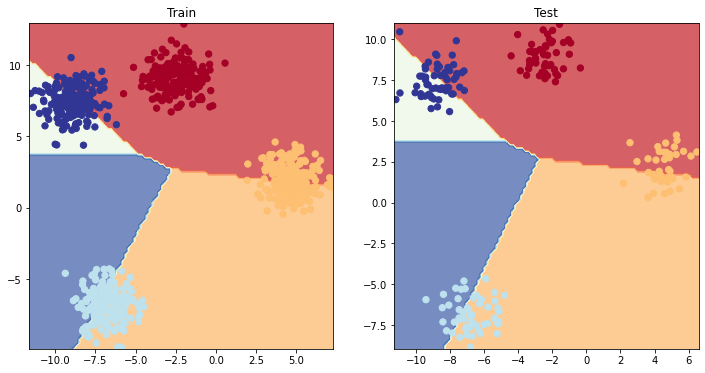

In [180]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)